In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

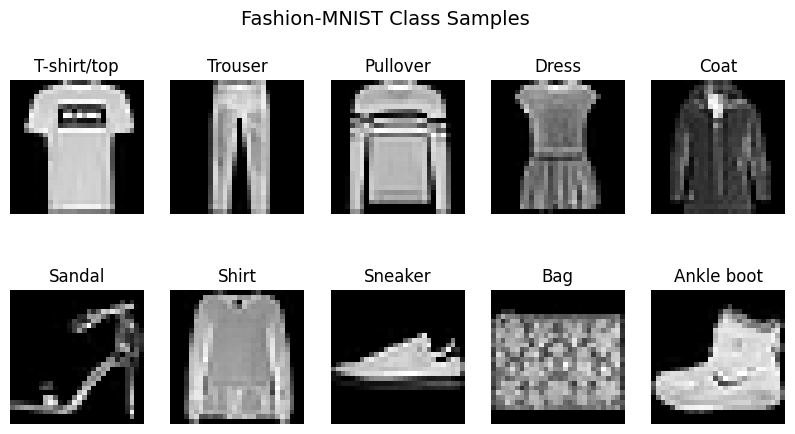

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

unique_classes = np.unique(train_labels)
sample_images = []
for cls in unique_classes:
    # the first occurence of each class
    index = np.where(train_labels == cls)[0][0]
    sample_images.append(train_images[index])

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Class Samples", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

plt.show()

In [4]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
import numpy as np

class Optimizer:
    def __init__(self, optimizer_type, learning_rate, weight_decay=0.0):
        self.optimizer_type = optimizer_type.lower()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.t = 1  # For Adam/Nadam
        self.gamma = 0.9  # Momentum/Nesterov
        self.beta1 = 0.9  # Adam/Nadam
        self.beta2 = 0.999  # Adam/Nadam
        self.epsilon = 1e-8  # Small value to prevent division by zero
        self.velocities_w = None
        self.velocities_b = None
        self.m_w = None
        self.v_w = None

    def initialize_momentum_buffers(self, weights, biases):
        if self.velocities_w is None:
            self.velocities_w = [np.zeros_like(w) for w in weights]
            self.velocities_b = [np.zeros_like(b) for b in biases]

    def initialize_adam_buffers(self, weights):
        if self.m_w is None:
            self.m_w = [np.zeros_like(w) for w in weights]
            self.v_w = [np.zeros_like(w) for w in weights]

    def sgd(self, weights, biases, grads_w, grads_b):
        step_size = self.learning_rate
        reg_factor = self.weight_decay

        for idx in range(len(weights)):
            weight_update = step_size * (grads_w[idx] + reg_factor * weights[idx])
            bias_update = step_size * grads_b[idx]

            weights[idx] -= weight_update
            biases[idx] -= bias_update


    def momentum(self, weights, biases, grads_w, grads_b):
        self.initialize_momentum_buffers(weights, biases)

        step_size = self.learning_rate
        decay_factor = self.weight_decay
        momentum_factor = self.gamma

        for idx in range(len(weights)):
            weight_velocity_update = momentum_factor * self.velocities_w[idx] + step_size * grads_w[idx]
            self.velocities_w[idx] = weight_velocity_update
            weights[idx] -= weight_velocity_update + step_size * decay_factor * weights[idx]

            bias_velocity_update = momentum_factor * self.velocities_b[idx] + step_size * grads_b[idx]
            self.velocities_b[idx] = bias_velocity_update
            biases[idx] -= bias_velocity_update


    def nesterov(self, w, g_w):
        self.initialize_momentum_buffers(w, w)

        gamma, lr, wd = self.gamma, self.learning_rate, self.weight_decay

        for idx in range(len(w)):
            v_old = self.velocities_w[idx]
            self.velocities_w[idx] = gamma * v_old + lr * g_w[idx]
            w[idx] -= gamma * v_old + (1 + gamma) * self.velocities_w[idx] + lr * wd * w[idx]


    def rmsprop(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, lr, wd, eps = self.beta1, self.learning_rate, self.weight_decay, self.epsilon

        for idx in range(len(w)):
            self.v_w[idx] = b1 * self.v_w[idx] + (1 - b1) * g_w[idx] ** 2
            w[idx] -= lr * g_w[idx] / (np.sqrt(self.v_w[idx]) + eps) + lr * wd * w[idx]


    def adam(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = b1 * self.m_w[idx] + (1 - b1) * g_w[idx]
            self.v_w[idx] = b2 * self.v_w[idx] + (1 - b2) * g_w[idx] ** 2

            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)

            w[idx] -= lr * m_hat / (np.sqrt(v_hat) + eps) + lr * wd * w[idx]


    def nadam(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = b1 * self.m_w[idx] + (1 - b1) * g_w[idx]
            self.v_w[idx] = b2 * self.v_w[idx] + (1 - b2) * g_w[idx] ** 2

            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)

            w[idx] -= lr * ((b1 * m_hat + (1 - b1) * g_w[idx] / (1 - b1 ** t)) / (np.sqrt(v_hat) + eps)) + lr * wd * w[idx]


    def update_weights(self, weights, biases, grads_w, grads_b):
        if self.optimizer_type == "sgd":
            self.sgd(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "momentum":
            self.momentum(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "nesterov":
            self.nesterov(weights, grads_w)
        elif self.optimizer_type == "rmsprop":
            self.rmsprop(weights, grads_w)
        elif self.optimizer_type == "adam":
            self.adam(weights, grads_w)
        elif self.optimizer_type == "nadam":
            self.nadam(weights, grads_w)

        self.t += 1  # Increment step counter for Adam/Nadam


In [12]:

class ActivationFunctions:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def derivative(name, x):
        if name == "tanh":
            return 1 - np.tanh(x) ** 2
        elif name == "sigmoid":
            sig = ActivationFunctions.sigmoid(x)
            return sig * (1 - sig)
        elif name == "relu":
            return (x > 0).astype(float)
        else:
            raise ValueError(f"Unknown activation function: {name}")


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizing images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9 * x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# One-hot encoding labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)


# Define Neural Network class
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, optimizer="sgd", weight_decay=0.0, weight_init="random", activation="relu", loss="cross_entropy"):
        self.opt = Optimizer(optimizer, learning_rate, weight_decay)
        self.layers = layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.weight_init = weight_init
        self.activation = activation.lower()
        self.initialize_weights()
        self.loss = loss

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(2 / (self.layers[i] + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)

            self.biases.append(np.zeros((1, self.layers[i+1])))

        self.velocities_w = [np.zeros_like(w) for w in self.weights]
        self.velocities_b = [np.zeros_like(b) for b in self.biases]
        self.m_w, self.v_w = [np.zeros_like(w) for w in self.weights], [np.zeros_like(w) for w in self.weights]
        self.m_b, self.v_b = [np.zeros_like(b) for b in self.biases], [np.zeros_like(b) for b in self.biases]
        self.t = 1

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == "tanh":
            return ActivationFunctions.tanh(x)
        if self.activation == "sigmoid":
            return ActivationFunctions.sigmoid(x)
        if self.activation == "relu":
            return ActivationFunctions.relu(x)

    def forward(self, x):
        self.activations = [x]
        for i in range(len(self.weights) - 1):
            x = self.activate(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x

    def activation_derivative(self, x):
        return ActivationFunctions.derivative(self.activation, x)

    def backward(self, x, y, dz):
        m = y.shape[0]
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        # Compute gradient of cross-entropy loss w.r.t. softmax input
        # dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:  # No activation applied to the input layer
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.activations[i])

        self.update_weights(grads_w, grads_b)


    def backwardwodz(self, x, y):
        m = y.shape[0]
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * (self.activations[i] > 0)

        self.update_weights(grads_w, grads_b)

    def update_weights(self, grads_w, grads_b):
        self.opt.update_weights(self.weights, self.biases, grads_w, grads_b)


    def train(self, x, y, x_val, y_val, epochs=10, batch_size=64):
        for epoch in range(epochs):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x, y = x[indices], y[indices]

            total_loss = 0
            correct_predictions = 0
            num_samples = 0

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(x_batch)

                # Compute loss based on selected loss function
                if self.loss == "cross_entropy":
                    batch_loss = -np.mean(np.sum(y_batch * np.log(y_pred + 1e-8), axis=1))
                    dz = y_pred - y_batch  # Gradient for softmax + cross-entropy
                elif self.loss == "squared_error":
                    batch_loss = np.mean((y_pred - y_batch) ** 2)
                    dz = 2 * (y_pred - y_batch) / y_batch.shape[0]  # Gradient for squared error

                total_loss += batch_loss * x_batch.shape[0]  # Accumulate weighted loss

                # Compute batch accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct
                num_samples += x_batch.shape[0]

                # Backward pass
                self.backward(x_batch, y_batch, dz)

            # Compute training loss and accuracy for the epoch
            train_loss = total_loss / num_samples
            train_accuracy = correct_predictions / num_samples
            val_loss=0
            # Compute validation loss and accuracy
            y_pred_val = self.forward(x_val)
            if self.loss == "cross_entropy":
                val_loss = -np.mean(np.sum(y_val * np.log(y_pred_val + 1e-8), axis=1))
            elif self.loss == "squared_error":
                val_loss = np.mean((y_pred_val - y_val) ** 2)

            val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1))

            # Log metrics to Weights & Biases
            # wandb.log({
            #     "epoch": epoch + 1,
            #     "Train Loss": train_loss,
            #     "Train Accuracy": train_accuracy,
            #     "Validation Loss": val_loss,
            #     "Validation Accuracy": val_accuracy
            # })

            # Print metrics
            print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")


    def evaluate(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred_labels == y_true_labels)
        loss = -np.mean(np.sum(y * np.log(y_pred + 1e-8), axis=1))  # Compute test loss

        print(f"Test Accuracy: {accuracy * 100:.2f}%, Test Loss: {loss:.4f}")

        return loss, accuracy, y_true_labels, y_pred_labels  # Return y_true and y_pred







In [16]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 130, 130, 130, 10], learning_rate=0.005, optimizer="nadam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=10, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy * 100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/10 - Train Acc: 0.7813, Train Loss: 0.5824, Val Acc: 0.8443, Val Loss: 0.4298


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

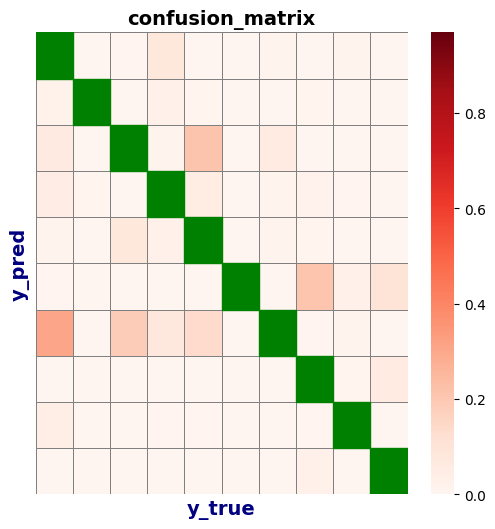

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize for better visualization
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure
plt.figure(figsize=(6, 6))

# Use a light red colormap for off-diagonal values
ax = sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Reds", linewidths=0.5, linecolor="gray")

# Manually highlight diagonal elements in green
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:  # Diagonal elements (correct predictions)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=1))

# Labels
plt.xlabel("y_true", fontsize=14, fontweight="bold", color="navy")
plt.ylabel("y_pred", fontsize=14, fontweight="bold", color="navy")
plt.title("confusion_matrix", fontsize=14, fontweight="bold")

# Remove unnecessary ticks for cleaner visualization
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()


In [11]:
def train_sweep():
    run = wandb.init()
    config = wandb.config

    # Generate a custom run name
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    wandb.run.name = run_name
    wandb.run.save()

    # Initialize and train the model
    model = NeuralNetwork(
        layers=[784] + [config.layer_size] * config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer,
        weight_decay=config.weight_decay,
        weight_init=config.weight_init,
        activation=config.activation
    )
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=config.epochs, batch_size=config.batch_size)

    # Evaluate on test data after training
    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    # Log final test metrics
    wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    run.finish()


In [12]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-hyperparam-tuning")
wandb.agent(sweep_id, function=train_sweep, count=300)

Create sweep with ID: beprb6r0
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/fashion-mnist-hyperparam-tuning/sweeps/beprb6r0


wandb: Agent Starting Run: alg3okyk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.1246, Train Loss: 2.3026, Val Acc: 0.1380, Val Loss: 2.3026
Epoch 2/10 - Train Acc: 0.1405, Train Loss: 2.3026, Val Acc: 0.1400, Val Loss: 2.3026
Epoch 3/10 - Train Acc: 0.1404, Train Loss: 2.3026, Val Acc: 0.1402, Val Loss: 2.3026
Epoch 4/10 - Train Acc: 0.1390, Train Loss: 2.3026, Val Acc: 0.1380, Val Loss: 2.3026
Epoch 5/10 - Train Acc: 0.1372, Train Loss: 2.3026, Val Acc: 0.1355, Val Loss: 2.3026
Epoch 6/10 - Train Acc: 0.1344, Train Loss: 2.3026, Val Acc: 0.1332, Val Loss: 2.3026
Epoch 7/10 - Train Acc: 0.1314, Train Loss: 2.3026, Val Acc: 0.1282, Val Loss: 2.3026
Epoch 8/10 - Train Acc: 0.1258, Train Loss: 2.3026, Val Acc: 0.1215, Val Loss: 2.3026
Epoch 9/10 - Train Acc: 0.1209, Train Loss: 2.3026, Val Acc: 0.1147, Val Loss: 2.3026
Epoch 10/10 - Train Acc: 0.1137, Train Loss: 2.3026, Val Acc: 0.1070, Val Loss: 2.3026
Test Accuracy: 10.96%, Test Loss: 2.3026
Final Test Accuracy: 0.1096, Test Loss: 2.3026


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▄███▇▆▆▄▃▁
Train Loss,██▇▇▇▆▆▅▃▁
Validation Accuracy,████▇▇▅▄▃▁
Validation Loss,███▇▇▇▆▅▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1096
Test Loss,2.30255
Train Accuracy,0.1137
Train Loss,2.30256


wandb: Agent Starting Run: 914dvdgh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.1327, Train Loss: 2.2701, Val Acc: 0.1735, Val Loss: 2.1279
Epoch 2/10 - Train Acc: 0.1786, Train Loss: 2.0773, Val Acc: 0.1715, Val Loss: 2.0683
Epoch 3/10 - Train Acc: 0.1796, Train Loss: 2.0442, Val Acc: 0.1785, Val Loss: 2.0429
Epoch 4/10 - Train Acc: 0.1837, Train Loss: 2.0206, Val Acc: 0.1783, Val Loss: 2.0271
Epoch 5/10 - Train Acc: 0.1861, Train Loss: 2.0015, Val Acc: 0.1803, Val Loss: 2.0110
Epoch 6/10 - Train Acc: 0.1887, Train Loss: 1.9851, Val Acc: 0.1805, Val Loss: 1.9847
Epoch 7/10 - Train Acc: 0.1866, Train Loss: 1.9677, Val Acc: 0.1852, Val Loss: 1.9705
Epoch 8/10 - Train Acc: 0.1903, Train Loss: 1.9471, Val Acc: 0.1825, Val Loss: 1.9590
Epoch 9/10 - Train Acc: 0.1919, Train Loss: 1.9292, Val Acc: 0.1917, Val Loss: 1.9410
Epoch 10/10 - Train Acc: 0.1941, Train Loss: 1.9116, Val Acc: 0.1895, Val Loss: 1.9198
Test Accuracy: 19.49%, Test Loss: 1.9011
Final Test Accuracy: 0.1949, Test Loss: 1.9011


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇▇███
Train Loss,█▄▄▃▃▂▂▂▁▁
Validation Accuracy,▂▁▃▃▄▄▆▅█▇
Validation Loss,█▆▅▅▄▃▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1949
Test Loss,1.90114
Train Accuracy,0.19409
Train Loss,1.91155


wandb: Agent Starting Run: 3rcysrvc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7934, Train Loss: 0.5972, Val Acc: 0.8353, Val Loss: 0.4664
Epoch 2/10 - Train Acc: 0.8471, Train Loss: 0.4306, Val Acc: 0.8493, Val Loss: 0.4212
Epoch 3/10 - Train Acc: 0.8580, Train Loss: 0.3954, Val Acc: 0.8550, Val Loss: 0.4011
Epoch 4/10 - Train Acc: 0.8680, Train Loss: 0.3709, Val Acc: 0.8600, Val Loss: 0.3945
Epoch 5/10 - Train Acc: 0.8723, Train Loss: 0.3545, Val Acc: 0.8658, Val Loss: 0.3737
Epoch 6/10 - Train Acc: 0.8765, Train Loss: 0.3427, Val Acc: 0.8617, Val Loss: 0.3812
Epoch 7/10 - Train Acc: 0.8810, Train Loss: 0.3298, Val Acc: 0.8640, Val Loss: 0.3722
Epoch 8/10 - Train Acc: 0.8835, Train Loss: 0.3209, Val Acc: 0.8645, Val Loss: 0.3814
Epoch 9/10 - Train Acc: 0.8870, Train Loss: 0.3127, Val Acc: 0.8703, Val Loss: 0.3526
Epoch 10/10 - Train Acc: 0.8878, Train Loss: 0.3052, Val Acc: 0.8540, Val Loss: 0.4260
Test Accuracy: 84.34%, Test Loss: 0.4427
Final Test Accuracy: 0.8434, Test Loss: 0.4427


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▇▆▇▇█▅
Validation Loss,█▅▄▄▂▃▂▃▁▆
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8434
Test Loss,0.44274
Train Accuracy,0.88776
Train Loss,0.30517


wandb: Agent Starting Run: qsv748lf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.1104, Train Loss: 2.3026, Val Acc: 0.1135, Val Loss: 2.3026
Epoch 2/5 - Train Acc: 0.1221, Train Loss: 2.3026, Val Acc: 0.1278, Val Loss: 2.3025
Epoch 3/5 - Train Acc: 0.1400, Train Loss: 2.3025, Val Acc: 0.1492, Val Loss: 2.3025
Epoch 4/5 - Train Acc: 0.1613, Train Loss: 2.3025, Val Acc: 0.1605, Val Loss: 2.3025
Epoch 5/5 - Train Acc: 0.1575, Train Loss: 2.3025, Val Acc: 0.1475, Val Loss: 2.3024
Test Accuracy: 13.94%, Test Loss: 2.3025
Final Test Accuracy: 0.1394, Test Loss: 2.3025


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▃▅█▇
Train Loss,█▇▅▄▁
Validation Accuracy,▁▃▆█▆
Validation Loss,█▇▅▄▁
epoch,▁▃▅▆█
Test Accuracy,0.1394
Test Loss,2.30245
Train Accuracy,0.15746
Train Loss,2.30248


wandb: Agent Starting Run: mz9904in with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.1812, Train Loss: 2.2579, Val Acc: 0.2465, Val Loss: 2.1360
Epoch 2/10 - Train Acc: 0.3010, Train Loss: 2.0358, Val Acc: 0.3302, Val Loss: 1.9460
Epoch 3/10 - Train Acc: 0.3819, Train Loss: 1.8674, Val Acc: 0.4155, Val Loss: 1.7953
Epoch 4/10 - Train Acc: 0.4567, Train Loss: 1.7364, Val Acc: 0.4835, Val Loss: 1.6831
Epoch 5/10 - Train Acc: 0.5056, Train Loss: 1.6388, Val Acc: 0.5217, Val Loss: 1.5982
Epoch 6/10 - Train Acc: 0.5390, Train Loss: 1.5627, Val Acc: 0.5522, Val Loss: 1.5307
Epoch 7/10 - Train Acc: 0.5634, Train Loss: 1.5013, Val Acc: 0.5798, Val Loss: 1.4756
Epoch 8/10 - Train Acc: 0.5893, Train Loss: 1.4515, Val Acc: 0.6047, Val Loss: 1.4309
Epoch 9/10 - Train Acc: 0.6127, Train Loss: 1.4092, Val Acc: 0.6287, Val Loss: 1.3916
Epoch 10/10 - Train Acc: 0.6323, Train Loss: 1.3700, Val Acc: 0.6467, Val Loss: 1.3531
Test Accuracy: 62.93%, Test Loss: 1.3580
Final Test Accuracy: 0.6293, Test Loss: 1.3580


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▃▄▅▆▇▇▇██
Train Loss,█▆▅▄▃▃▂▂▁▁
Validation Accuracy,▁▂▄▅▆▆▇▇██
Validation Loss,█▆▅▄▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.6293
Test Loss,1.358
Train Accuracy,0.63226
Train Loss,1.37005


wandb: Agent Starting Run: kpepzda4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.1171, Train Loss: 2.3903, Val Acc: 0.1168, Val Loss: 2.3661
Epoch 2/5 - Train Acc: 0.1284, Train Loss: 2.3410, Val Acc: 0.1267, Val Loss: 2.3272
Epoch 3/5 - Train Acc: 0.1394, Train Loss: 2.3116, Val Acc: 0.1393, Val Loss: 2.3041
Epoch 4/5 - Train Acc: 0.1489, Train Loss: 2.2947, Val Acc: 0.1467, Val Loss: 2.2909
Epoch 5/5 - Train Acc: 0.1579, Train Loss: 2.2854, Val Acc: 0.1540, Val Loss: 2.2840
Test Accuracy: 16.10%, Test Loss: 2.2830
Final Test Accuracy: 0.1610, Test Loss: 2.2830


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▃▅▆█
Train Loss,█▅▃▂▁
Validation Accuracy,▁▃▅▇█
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.161
Test Loss,2.28296
Train Accuracy,0.15793
Train Loss,2.28541


wandb: Agent Starting Run: jnnauzqa with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.0975, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Epoch 2/5 - Train Acc: 0.1009, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Epoch 3/5 - Train Acc: 0.1014, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Epoch 4/5 - Train Acc: 0.1011, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Epoch 5/5 - Train Acc: 0.1008, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Test Accuracy: 10.00%, Test Loss: 2.3026
Final Test Accuracy: 0.1000, Test Loss: 2.3026


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇██▇
Train Loss,█▁▂▃▄
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▂▄▆█
epoch,▁▃▅▆█
Test Accuracy,0.1
Test Loss,2.30258
Train Accuracy,0.10083
Train Loss,2.30258


wandb: Agent Starting Run: q8u38u5r with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5070, Train Loss: 1.1532, Val Acc: 0.6318, Val Loss: 0.9382
Epoch 2/5 - Train Acc: 0.6623, Train Loss: 0.8623, Val Acc: 0.7297, Val Loss: 0.7800
Epoch 3/5 - Train Acc: 0.7320, Train Loss: 0.7485, Val Acc: 0.7547, Val Loss: 0.7140
Epoch 4/5 - Train Acc: 0.7473, Train Loss: 0.7024, Val Acc: 0.7465, Val Loss: 0.7005
Epoch 5/5 - Train Acc: 0.7550, Train Loss: 0.6721, Val Acc: 0.7675, Val Loss: 0.6503
Test Accuracy: 75.74%, Test Loss: 0.6695
Final Test Accuracy: 0.7574, Test Loss: 0.6695


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.7574
Test Loss,0.66954
Train Accuracy,0.75498
Train Loss,0.67206


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3gqx1b8n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5045, Train Loss: 1.1556, Val Acc: 0.6002, Val Loss: 0.9625
Epoch 2/5 - Train Acc: 0.6117, Train Loss: 0.9428, Val Acc: 0.6175, Val Loss: 0.9254
Epoch 3/5 - Train Acc: 0.6364, Train Loss: 0.9111, Val Acc: 0.6542, Val Loss: 0.8810
Epoch 4/5 - Train Acc: 0.6504, Train Loss: 0.8951, Val Acc: 0.6723, Val Loss: 0.8687
Epoch 5/5 - Train Acc: 0.6547, Train Loss: 0.8858, Val Acc: 0.6738, Val Loss: 0.8684
Test Accuracy: 66.01%, Test Loss: 0.8855
Final Test Accuracy: 0.6601, Test Loss: 0.8855


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▃▆██
Validation Loss,█▅▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.6601
Test Loss,0.88554
Train Accuracy,0.6547
Train Loss,0.88577


wandb: Agent Starting Run: iw4w2tkb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.1776, Train Loss: 2.0156, Val Acc: 0.1868, Val Loss: 1.8436
Epoch 2/10 - Train Acc: 0.2001, Train Loss: 1.8217, Val Acc: 0.1868, Val Loss: 1.8185
Epoch 3/10 - Train Acc: 0.1985, Train Loss: 1.8120, Val Acc: 0.1980, Val Loss: 1.8130
Epoch 4/10 - Train Acc: 0.1975, Train Loss: 1.8059, Val Acc: 0.1940, Val Loss: 1.8049
Epoch 5/10 - Train Acc: 0.1976, Train Loss: 1.7986, Val Acc: 0.1865, Val Loss: 1.7987
Epoch 6/10 - Train Acc: 0.2031, Train Loss: 1.7890, Val Acc: 0.1932, Val Loss: 1.7927
Epoch 7/10 - Train Acc: 0.2022, Train Loss: 1.7807, Val Acc: 0.1900, Val Loss: 1.7791
Epoch 8/10 - Train Acc: 0.1987, Train Loss: 1.7704, Val Acc: 0.1898, Val Loss: 1.7718
Epoch 9/10 - Train Acc: 0.1961, Train Loss: 1.7595, Val Acc: 0.1933, Val Loss: 1.7637
Epoch 10/10 - Train Acc: 0.2009, Train Loss: 1.7505, Val Acc: 0.1933, Val Loss: 1.7593
Test Accuracy: 20.01%, Test Loss: 1.7529
Final Test Accuracy: 0.2001, Test Loss: 1.7529


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇▆▆██▇▆▇
Train Loss,█▃▃▂▂▂▂▂▁▁
Validation Accuracy,▁▁█▆▁▅▃▃▅▅
Validation Loss,█▆▅▅▄▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.2001
Test Loss,1.75286
Train Accuracy,0.20087
Train Loss,1.7505


wandb: Agent Starting Run: z1etmxc1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6198, Train Loss: 1.1661, Val Acc: 0.7642, Val Loss: 0.6935
Epoch 2/5 - Train Acc: 0.7869, Train Loss: 0.6312, Val Acc: 0.8017, Val Loss: 0.5789
Epoch 3/5 - Train Acc: 0.8129, Train Loss: 0.5539, Val Acc: 0.8172, Val Loss: 0.5253
Epoch 4/5 - Train Acc: 0.8248, Train Loss: 0.5133, Val Acc: 0.8272, Val Loss: 0.5008
Epoch 5/5 - Train Acc: 0.8334, Train Loss: 0.4901, Val Acc: 0.8365, Val Loss: 0.4844
Test Accuracy: 82.71%, Test Loss: 0.5061
Final Test Accuracy: 0.8271, Test Loss: 0.5061


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8271
Test Loss,0.50614
Train Accuracy,0.83343
Train Loss,0.49008


wandb: Agent Starting Run: 5ackn6vw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


<ipython-input-6-55619b9579d0>:63: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/5 - Train Acc: 0.1570, Train Loss: 2.1009, Val Acc: 0.1882, Val Loss: 1.8233
Epoch 2/5 - Train Acc: 0.1977, Train Loss: 1.7757, Val Acc: 0.1937, Val Loss: 1.7619
Epoch 3/5 - Train Acc: 0.1922, Train Loss: 1.8313, Val Acc: 0.1992, Val Loss: 1.8215
Epoch 4/5 - Train Acc: 0.1949, Train Loss: 1.7855, Val Acc: 0.1998, Val Loss: 1.7657
Epoch 5/5 - Train Acc: 0.1953, Train Loss: 1.7856, Val Acc: 0.1948, Val Loss: 1.7882
Test Accuracy: 19.88%, Test Loss: 1.7969
Final Test Accuracy: 0.1988, Test Loss: 1.7969


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█▇██
Train Loss,█▁▂▁▁
Validation Accuracy,▁▄██▅
Validation Loss,█▁█▁▄
epoch,▁▃▅▆█
Test Accuracy,0.1988
Test Loss,1.79687
Train Accuracy,0.1953
Train Loss,1.78561


wandb: Agent Starting Run: 1gl545ol with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.3434, Train Loss: 1.5949, Val Acc: 0.3558, Val Loss: 1.5361
Epoch 2/5 - Train Acc: 0.3488, Train Loss: 1.5329, Val Acc: 0.3588, Val Loss: 1.5277
Epoch 3/5 - Train Acc: 0.3510, Train Loss: 1.5277, Val Acc: 0.3442, Val Loss: 1.5551
Epoch 4/5 - Train Acc: 0.3646, Train Loss: 1.5443, Val Acc: 0.3985, Val Loss: 1.5716
Epoch 5/5 - Train Acc: 0.3846, Train Loss: 1.5169, Val Acc: 0.3820, Val Loss: 1.4991
Test Accuracy: 38.52%, Test Loss: 1.4910
Final Test Accuracy: 0.3852, Test Loss: 1.4910


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▂▂▅█
Train Loss,█▂▂▃▁
Validation Accuracy,▃▃▁█▆
Validation Loss,▅▄▆█▁
epoch,▁▃▅▆█
Test Accuracy,0.3852
Test Loss,1.49104
Train Accuracy,0.38463
Train Loss,1.51685


wandb: Agent Starting Run: jl1puvf7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.4159, Train Loss: 1.4351, Val Acc: 0.4490, Val Loss: 1.2923
Epoch 2/5 - Train Acc: 0.4728, Train Loss: 1.3092, Val Acc: 0.5332, Val Loss: 1.1500
Epoch 3/5 - Train Acc: 0.5609, Train Loss: 1.0946, Val Acc: 0.4470, Val Loss: 1.3438
Epoch 4/5 - Train Acc: 0.3792, Train Loss: 1.5733, Val Acc: 0.4755, Val Loss: 1.4166
Epoch 5/5 - Train Acc: 0.5036, Train Loss: 1.2879, Val Acc: 0.5515, Val Loss: 1.1731
Test Accuracy: 55.36%, Test Loss: 1.1684
Final Test Accuracy: 0.5536, Test Loss: 1.1684


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▂▅█▁▆
Train Loss,▆▄▁█▄
Validation Accuracy,▁▇▁▃█
Validation Loss,▅▁▆█▂
epoch,▁▃▅▆█
Test Accuracy,0.5536
Test Loss,1.16845
Train Accuracy,0.50359
Train Loss,1.28793


wandb: Agent Starting Run: hm9nmxka with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.1606, Train Loss: 2.1415, Val Acc: 0.1903, Val Loss: 1.8988
Epoch 2/10 - Train Acc: 0.2007, Train Loss: 1.8545, Val Acc: 0.1897, Val Loss: 1.8457
Epoch 3/10 - Train Acc: 0.1999, Train Loss: 1.8244, Val Acc: 0.1865, Val Loss: 1.8267
Epoch 4/10 - Train Acc: 0.1982, Train Loss: 1.8153, Val Acc: 0.1985, Val Loss: 1.8145
Epoch 5/10 - Train Acc: 0.1996, Train Loss: 1.8080, Val Acc: 0.1892, Val Loss: 1.8120
Epoch 6/10 - Train Acc: 0.2001, Train Loss: 1.8045, Val Acc: 0.1933, Val Loss: 1.8060
Epoch 7/10 - Train Acc: 0.1963, Train Loss: 1.8006, Val Acc: 0.1930, Val Loss: 1.8051
Epoch 8/10 - Train Acc: 0.1986, Train Loss: 1.7974, Val Acc: 0.1868, Val Loss: 1.8038
Epoch 9/10 - Train Acc: 0.1996, Train Loss: 1.7955, Val Acc: 0.1982, Val Loss: 1.8000
Epoch 10/10 - Train Acc: 0.1966, Train Loss: 1.7922, Val Acc: 0.1865, Val Loss: 1.7977
Test Accuracy: 19.96%, Test Loss: 1.7877
Final Test Accuracy: 0.1996, Test Loss: 1.7877


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█████▇██▇
Train Loss,█▂▂▁▁▁▁▁▁▁
Validation Accuracy,▃▃▁█▃▅▅▁█▁
Validation Loss,█▄▃▂▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1996
Test Loss,1.78767
Train Accuracy,0.19656
Train Loss,1.79217


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kjd2fv3p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8201, Train Loss: 0.5078, Val Acc: 0.8503, Val Loss: 0.4102
Epoch 2/10 - Train Acc: 0.8641, Train Loss: 0.3746, Val Acc: 0.8638, Val Loss: 0.3707
Epoch 3/10 - Train Acc: 0.8739, Train Loss: 0.3439, Val Acc: 0.8608, Val Loss: 0.3881
Epoch 4/10 - Train Acc: 0.8829, Train Loss: 0.3211, Val Acc: 0.8743, Val Loss: 0.3484
Epoch 5/10 - Train Acc: 0.8879, Train Loss: 0.3047, Val Acc: 0.8685, Val Loss: 0.3671
Epoch 6/10 - Train Acc: 0.8917, Train Loss: 0.2923, Val Acc: 0.8788, Val Loss: 0.3434
Epoch 7/10 - Train Acc: 0.8972, Train Loss: 0.2808, Val Acc: 0.8745, Val Loss: 0.3436
Epoch 8/10 - Train Acc: 0.8993, Train Loss: 0.2696, Val Acc: 0.8807, Val Loss: 0.3290
Epoch 9/10 - Train Acc: 0.9023, Train Loss: 0.2618, Val Acc: 0.8832, Val Loss: 0.3484
Epoch 10/10 - Train Acc: 0.9044, Train Loss: 0.2543, Val Acc: 0.8817, Val Loss: 0.3408
Test Accuracy: 87.37%, Test Loss: 0.3652
Final Test Accuracy: 0.8737, Test Loss: 0.3652


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▅▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▃▆▅▇▆▇██
Validation Loss,█▅▆▃▄▂▂▁▃▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8737
Test Loss,0.3652
Train Accuracy,0.90437
Train Loss,0.25425


wandb: Agent Starting Run: hfrxjwb8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6196, Train Loss: 1.1423, Val Acc: 0.7697, Val Loss: 0.6693
Epoch 2/10 - Train Acc: 0.7866, Train Loss: 0.6088, Val Acc: 0.7975, Val Loss: 0.5649
Epoch 3/10 - Train Acc: 0.8083, Train Loss: 0.5463, Val Acc: 0.8100, Val Loss: 0.5299
Epoch 4/10 - Train Acc: 0.8182, Train Loss: 0.5176, Val Acc: 0.8227, Val Loss: 0.5062
Epoch 5/10 - Train Acc: 0.8283, Train Loss: 0.4979, Val Acc: 0.8320, Val Loss: 0.4934
Epoch 6/10 - Train Acc: 0.8356, Train Loss: 0.4832, Val Acc: 0.8327, Val Loss: 0.4781
Epoch 7/10 - Train Acc: 0.8389, Train Loss: 0.4730, Val Acc: 0.8365, Val Loss: 0.4708
Epoch 8/10 - Train Acc: 0.8429, Train Loss: 0.4642, Val Acc: 0.8412, Val Loss: 0.4670
Epoch 9/10 - Train Acc: 0.8468, Train Loss: 0.4578, Val Acc: 0.8413, Val Loss: 0.4570
Epoch 10/10 - Train Acc: 0.8480, Train Loss: 0.4519, Val Acc: 0.8478, Val Loss: 0.4535
Test Accuracy: 83.57%, Test Loss: 0.4843
Final Test Accuracy: 0.8357, Test Loss: 0.4843


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▁▁▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇▇▇▇█
Validation Loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8357
Test Loss,0.48425
Train Accuracy,0.84804
Train Loss,0.45193


wandb: Agent Starting Run: xvobl31w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7493, Train Loss: 0.7729, Val Acc: 0.8295, Val Loss: 0.5006
Epoch 2/10 - Train Acc: 0.8383, Train Loss: 0.4736, Val Acc: 0.8458, Val Loss: 0.4465
Epoch 3/10 - Train Acc: 0.8513, Train Loss: 0.4306, Val Acc: 0.8507, Val Loss: 0.4285
Epoch 4/10 - Train Acc: 0.8585, Train Loss: 0.4070, Val Acc: 0.8550, Val Loss: 0.4075
Epoch 5/10 - Train Acc: 0.8647, Train Loss: 0.3911, Val Acc: 0.8603, Val Loss: 0.3936
Epoch 6/10 - Train Acc: 0.8684, Train Loss: 0.3777, Val Acc: 0.8630, Val Loss: 0.3863
Epoch 7/10 - Train Acc: 0.8725, Train Loss: 0.3680, Val Acc: 0.8687, Val Loss: 0.3739
Epoch 8/10 - Train Acc: 0.8756, Train Loss: 0.3590, Val Acc: 0.8668, Val Loss: 0.3802
Epoch 9/10 - Train Acc: 0.8773, Train Loss: 0.3516, Val Acc: 0.8708, Val Loss: 0.3757
Epoch 10/10 - Train Acc: 0.8796, Train Loss: 0.3446, Val Acc: 0.8723, Val Loss: 0.3651
Test Accuracy: 86.49%, Test Loss: 0.3895
Final Test Accuracy: 0.8649, Test Loss: 0.3895


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▄▅▆▆▇▇██
Validation Loss,█▅▄▃▂▂▁▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8649
Test Loss,0.38954
Train Accuracy,0.87961
Train Loss,0.34455


wandb: Agent Starting Run: 39eesse9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7002, Train Loss: 0.9515, Val Acc: 0.8042, Val Loss: 0.5798
Epoch 2/10 - Train Acc: 0.8203, Train Loss: 0.5291, Val Acc: 0.8348, Val Loss: 0.4934
Epoch 3/10 - Train Acc: 0.8383, Train Loss: 0.4778, Val Acc: 0.8387, Val Loss: 0.4653
Epoch 4/10 - Train Acc: 0.8456, Train Loss: 0.4523, Val Acc: 0.8425, Val Loss: 0.4525
Epoch 5/10 - Train Acc: 0.8501, Train Loss: 0.4360, Val Acc: 0.8480, Val Loss: 0.4354
Epoch 6/10 - Train Acc: 0.8551, Train Loss: 0.4230, Val Acc: 0.8475, Val Loss: 0.4299
Epoch 7/10 - Train Acc: 0.8578, Train Loss: 0.4133, Val Acc: 0.8575, Val Loss: 0.4140
Epoch 8/10 - Train Acc: 0.8614, Train Loss: 0.4051, Val Acc: 0.8595, Val Loss: 0.4113
Epoch 9/10 - Train Acc: 0.8626, Train Loss: 0.3982, Val Acc: 0.8533, Val Loss: 0.4120
Epoch 10/10 - Train Acc: 0.8656, Train Loss: 0.3917, Val Acc: 0.8595, Val Loss: 0.4002
Test Accuracy: 85.34%, Test Loss: 0.4225
Final Test Accuracy: 0.8534, Test Loss: 0.4225


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▅▆▇▆██▇█
Validation Loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8534
Test Loss,0.42249
Train Accuracy,0.86565
Train Loss,0.39166


wandb: Agent Starting Run: q7vrysqw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7340, Train Loss: 0.7923, Val Acc: 0.8128, Val Loss: 0.5278
Epoch 2/5 - Train Acc: 0.8298, Train Loss: 0.4926, Val Acc: 0.8338, Val Loss: 0.4688
Epoch 3/5 - Train Acc: 0.8455, Train Loss: 0.4432, Val Acc: 0.8435, Val Loss: 0.4379
Epoch 4/5 - Train Acc: 0.8558, Train Loss: 0.4153, Val Acc: 0.8512, Val Loss: 0.4162
Epoch 5/5 - Train Acc: 0.8619, Train Loss: 0.3960, Val Acc: 0.8517, Val Loss: 0.4123
Test Accuracy: 84.45%, Test Loss: 0.4350
Final Test Accuracy: 0.8445, Test Loss: 0.4350


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8445
Test Loss,0.43495
Train Accuracy,0.86191
Train Loss,0.39603


wandb: Agent Starting Run: g3n52czl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7557, Train Loss: 0.7202, Val Acc: 0.8185, Val Loss: 0.5271
Epoch 2/10 - Train Acc: 0.8314, Train Loss: 0.5000, Val Acc: 0.8342, Val Loss: 0.4825
Epoch 3/10 - Train Acc: 0.8413, Train Loss: 0.4676, Val Acc: 0.8410, Val Loss: 0.4548
Epoch 4/10 - Train Acc: 0.8465, Train Loss: 0.4514, Val Acc: 0.8500, Val Loss: 0.4444
Epoch 5/10 - Train Acc: 0.8512, Train Loss: 0.4415, Val Acc: 0.8515, Val Loss: 0.4369
Epoch 6/10 - Train Acc: 0.8538, Train Loss: 0.4348, Val Acc: 0.8490, Val Loss: 0.4408
Epoch 7/10 - Train Acc: 0.8547, Train Loss: 0.4313, Val Acc: 0.8507, Val Loss: 0.4362
Epoch 8/10 - Train Acc: 0.8567, Train Loss: 0.4263, Val Acc: 0.8598, Val Loss: 0.4214
Epoch 9/10 - Train Acc: 0.8577, Train Loss: 0.4225, Val Acc: 0.8547, Val Loss: 0.4281
Epoch 10/10 - Train Acc: 0.8598, Train Loss: 0.4195, Val Acc: 0.8558, Val Loss: 0.4250
Test Accuracy: 84.56%, Test Loss: 0.4492
Final Test Accuracy: 0.8456, Test Loss: 0.4492


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▆▆█▇▇
Validation Loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8456
Test Loss,0.44923
Train Accuracy,0.85978
Train Loss,0.4195


wandb: Agent Starting Run: goh3b8zz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7879, Train Loss: 0.6092, Val Acc: 0.8392, Val Loss: 0.4578
Epoch 2/5 - Train Acc: 0.8514, Train Loss: 0.4208, Val Acc: 0.8525, Val Loss: 0.4015
Epoch 3/5 - Train Acc: 0.8667, Train Loss: 0.3751, Val Acc: 0.8675, Val Loss: 0.3787
Epoch 4/5 - Train Acc: 0.8754, Train Loss: 0.3474, Val Acc: 0.8680, Val Loss: 0.3776
Epoch 5/5 - Train Acc: 0.8819, Train Loss: 0.3269, Val Acc: 0.8628, Val Loss: 0.3611
Test Accuracy: 86.21%, Test Loss: 0.3889
Final Test Accuracy: 0.8621, Test Loss: 0.3889


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▄██▇
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8621
Test Loss,0.38887
Train Accuracy,0.88187
Train Loss,0.32688


wandb: Agent Starting Run: 5vpk2m0n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8104, Train Loss: 0.5312, Val Acc: 0.8412, Val Loss: 0.4408
Epoch 2/5 - Train Acc: 0.8573, Train Loss: 0.3930, Val Acc: 0.8618, Val Loss: 0.3923
Epoch 3/5 - Train Acc: 0.8695, Train Loss: 0.3600, Val Acc: 0.8700, Val Loss: 0.3605
Epoch 4/5 - Train Acc: 0.8757, Train Loss: 0.3386, Val Acc: 0.8653, Val Loss: 0.3613
Epoch 5/5 - Train Acc: 0.8825, Train Loss: 0.3198, Val Acc: 0.8672, Val Loss: 0.3598
Test Accuracy: 86.51%, Test Loss: 0.3799
Final Test Accuracy: 0.8651, Test Loss: 0.3799


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▆█▇▇
Validation Loss,█▄▁▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8651
Test Loss,0.37988
Train Accuracy,0.88252
Train Loss,0.31981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wnh4efh6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8104, Train Loss: 0.5214, Val Acc: 0.8437, Val Loss: 0.4149
Epoch 2/10 - Train Acc: 0.8555, Train Loss: 0.3973, Val Acc: 0.8597, Val Loss: 0.3886
Epoch 3/10 - Train Acc: 0.8681, Train Loss: 0.3620, Val Acc: 0.8727, Val Loss: 0.3439
Epoch 4/10 - Train Acc: 0.8743, Train Loss: 0.3421, Val Acc: 0.8703, Val Loss: 0.3609
Epoch 5/10 - Train Acc: 0.8813, Train Loss: 0.3239, Val Acc: 0.8585, Val Loss: 0.4026
Epoch 6/10 - Train Acc: 0.8862, Train Loss: 0.3126, Val Acc: 0.8680, Val Loss: 0.3678
Epoch 7/10 - Train Acc: 0.8899, Train Loss: 0.3020, Val Acc: 0.8738, Val Loss: 0.3498
Epoch 8/10 - Train Acc: 0.8932, Train Loss: 0.2921, Val Acc: 0.8772, Val Loss: 0.3433
Epoch 9/10 - Train Acc: 0.8956, Train Loss: 0.2831, Val Acc: 0.8817, Val Loss: 0.3761
Epoch 10/10 - Train Acc: 0.8982, Train Loss: 0.2762, Val Acc: 0.8712, Val Loss: 0.3816
Test Accuracy: 86.89%, Test Loss: 0.3943
Final Test Accuracy: 0.8689, Test Loss: 0.3943


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▄▅▇▇█▆
Validation Loss,█▅▁▃▇▃▂▁▄▅
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8689
Test Loss,0.39431
Train Accuracy,0.8982
Train Loss,0.27617


wandb: Agent Starting Run: t9nz1wmc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8100, Train Loss: 0.5432, Val Acc: 0.8087, Val Loss: 0.5176
Epoch 2/5 - Train Acc: 0.8456, Train Loss: 0.4403, Val Acc: 0.8498, Val Loss: 0.4234
Epoch 3/5 - Train Acc: 0.8503, Train Loss: 0.4239, Val Acc: 0.8343, Val Loss: 0.4899
Epoch 4/5 - Train Acc: 0.8546, Train Loss: 0.4134, Val Acc: 0.8507, Val Loss: 0.4173
Epoch 5/5 - Train Acc: 0.8564, Train Loss: 0.4092, Val Acc: 0.8427, Val Loss: 0.4316
Test Accuracy: 83.98%, Test Loss: 0.4631
Final Test Accuracy: 0.8398, Test Loss: 0.4631


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁█▅█▇
Validation Loss,█▁▆▁▂
epoch,▁▃▅▆█
Test Accuracy,0.8398
Test Loss,0.46314
Train Accuracy,0.85637
Train Loss,0.40922


wandb: Agent Starting Run: u8mucpie with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7953, Train Loss: 0.5625, Val Acc: 0.8240, Val Loss: 0.5002
Epoch 2/5 - Train Acc: 0.8418, Train Loss: 0.4591, Val Acc: 0.8533, Val Loss: 0.4353
Epoch 3/5 - Train Acc: 0.8458, Train Loss: 0.4701, Val Acc: 0.8210, Val Loss: 0.5351
Epoch 4/5 - Train Acc: 0.8460, Train Loss: 0.4792, Val Acc: 0.8468, Val Loss: 0.4727
Epoch 5/5 - Train Acc: 0.8449, Train Loss: 0.4905, Val Acc: 0.8058, Val Loss: 0.5461
Test Accuracy: 79.68%, Test Loss: 0.5933
Final Test Accuracy: 0.7968, Test Loss: 0.5933


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇███
Train Loss,█▁▂▂▃
Validation Accuracy,▄█▃▇▁
Validation Loss,▅▁▇▃█
epoch,▁▃▅▆█
Test Accuracy,0.7968
Test Loss,0.5933
Train Accuracy,0.84489
Train Loss,0.49053


wandb: Agent Starting Run: tfr56cr4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6550, Train Loss: 0.9101, Val Acc: 0.7778, Val Loss: 0.6180
Epoch 2/5 - Train Acc: 0.8043, Train Loss: 0.5526, Val Acc: 0.8155, Val Loss: 0.5186
Epoch 3/5 - Train Acc: 0.8316, Train Loss: 0.4838, Val Acc: 0.8337, Val Loss: 0.4750
Epoch 4/5 - Train Acc: 0.8457, Train Loss: 0.4451, Val Acc: 0.8465, Val Loss: 0.4404
Epoch 5/5 - Train Acc: 0.8546, Train Loss: 0.4214, Val Acc: 0.8477, Val Loss: 0.4307
Test Accuracy: 84.50%, Test Loss: 0.4461
Final Test Accuracy: 0.8450, Test Loss: 0.4461


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.845
Test Loss,0.44611
Train Accuracy,0.85456
Train Loss,0.4214


wandb: Agent Starting Run: ygtz6e92 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7766, Train Loss: 0.6515, Val Acc: 0.8333, Val Loss: 0.4765
Epoch 2/5 - Train Acc: 0.8464, Train Loss: 0.4329, Val Acc: 0.8525, Val Loss: 0.4151
Epoch 3/5 - Train Acc: 0.8611, Train Loss: 0.3917, Val Acc: 0.8518, Val Loss: 0.4065
Epoch 4/5 - Train Acc: 0.8689, Train Loss: 0.3659, Val Acc: 0.8702, Val Loss: 0.3623
Epoch 5/5 - Train Acc: 0.8764, Train Loss: 0.3459, Val Acc: 0.8720, Val Loss: 0.3585
Test Accuracy: 86.17%, Test Loss: 0.3863
Final Test Accuracy: 0.8617, Test Loss: 0.3863


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▄██
Validation Loss,█▄▄▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8617
Test Loss,0.38626
Train Accuracy,0.87641
Train Loss,0.34593


wandb: Agent Starting Run: eg22a7co with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7764, Train Loss: 0.6501, Val Acc: 0.8392, Val Loss: 0.4556
Epoch 2/10 - Train Acc: 0.8487, Train Loss: 0.4257, Val Acc: 0.8532, Val Loss: 0.3992
Epoch 3/10 - Train Acc: 0.8618, Train Loss: 0.3859, Val Acc: 0.8643, Val Loss: 0.3812
Epoch 4/10 - Train Acc: 0.8713, Train Loss: 0.3601, Val Acc: 0.8618, Val Loss: 0.3766
Epoch 5/10 - Train Acc: 0.8774, Train Loss: 0.3411, Val Acc: 0.8715, Val Loss: 0.3526
Epoch 6/10 - Train Acc: 0.8811, Train Loss: 0.3264, Val Acc: 0.8752, Val Loss: 0.3498
Epoch 7/10 - Train Acc: 0.8876, Train Loss: 0.3124, Val Acc: 0.8733, Val Loss: 0.3390
Epoch 8/10 - Train Acc: 0.8906, Train Loss: 0.3009, Val Acc: 0.8743, Val Loss: 0.3438
Epoch 9/10 - Train Acc: 0.8949, Train Loss: 0.2898, Val Acc: 0.8775, Val Loss: 0.3376
Epoch 10/10 - Train Acc: 0.8970, Train Loss: 0.2812, Val Acc: 0.8845, Val Loss: 0.3277
Test Accuracy: 87.98%, Test Loss: 0.3447
Final Test Accuracy: 0.8798, Test Loss: 0.3447


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▇▆▆▇█
Validation Loss,█▅▄▄▂▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8798
Test Loss,0.34471
Train Accuracy,0.89704
Train Loss,0.28119


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m97s5b5p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7938, Train Loss: 0.5734, Val Acc: 0.8022, Val Loss: 0.5566
Epoch 2/5 - Train Acc: 0.8233, Train Loss: 0.5005, Val Acc: 0.7912, Val Loss: 0.5758
Epoch 3/5 - Train Acc: 0.8252, Train Loss: 0.4940, Val Acc: 0.8297, Val Loss: 0.4808
Epoch 4/5 - Train Acc: 0.8284, Train Loss: 0.4902, Val Acc: 0.7973, Val Loss: 0.5429
Epoch 5/5 - Train Acc: 0.8250, Train Loss: 0.4937, Val Acc: 0.8168, Val Loss: 0.5162
Test Accuracy: 80.81%, Test Loss: 0.5536
Final Test Accuracy: 0.8081, Test Loss: 0.5536


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇█▇
Train Loss,█▂▁▁▁
Validation Accuracy,▃▁█▂▆
Validation Loss,▇█▁▆▄
epoch,▁▃▅▆█
Test Accuracy,0.8081
Test Loss,0.55363
Train Accuracy,0.82502
Train Loss,0.49366


wandb: Agent Starting Run: 31viw9nb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7494, Train Loss: 0.7124, Val Acc: 0.8185, Val Loss: 0.5254
Epoch 2/5 - Train Acc: 0.8368, Train Loss: 0.4645, Val Acc: 0.8390, Val Loss: 0.4453
Epoch 3/5 - Train Acc: 0.8521, Train Loss: 0.4179, Val Acc: 0.8488, Val Loss: 0.4223
Epoch 4/5 - Train Acc: 0.8619, Train Loss: 0.3875, Val Acc: 0.8512, Val Loss: 0.4054
Epoch 5/5 - Train Acc: 0.8686, Train Loss: 0.3683, Val Acc: 0.8635, Val Loss: 0.3739
Test Accuracy: 85.85%, Test Loss: 0.3935
Final Test Accuracy: 0.8585, Test Loss: 0.3935


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▆█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8585
Test Loss,0.39351
Train Accuracy,0.86865
Train Loss,0.36828


wandb: Agent Starting Run: kufjnlwo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8034, Train Loss: 0.5532, Val Acc: 0.8267, Val Loss: 0.4761
Epoch 2/5 - Train Acc: 0.8308, Train Loss: 0.4808, Val Acc: 0.8228, Val Loss: 0.5039
Epoch 3/5 - Train Acc: 0.8333, Train Loss: 0.4726, Val Acc: 0.8397, Val Loss: 0.4476
Epoch 4/5 - Train Acc: 0.8339, Train Loss: 0.4681, Val Acc: 0.8190, Val Loss: 0.5256
Epoch 5/5 - Train Acc: 0.8350, Train Loss: 0.4650, Val Acc: 0.8462, Val Loss: 0.4475
Test Accuracy: 83.73%, Test Loss: 0.4679
Final Test Accuracy: 0.8373, Test Loss: 0.4679


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇███
Train Loss,█▂▂▁▁
Validation Accuracy,▃▂▆▁█
Validation Loss,▄▆▁█▁
epoch,▁▃▅▆█
Test Accuracy,0.8373
Test Loss,0.46792
Train Accuracy,0.83496
Train Loss,0.46498


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c4tz8jfy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7995, Train Loss: 0.5689, Val Acc: 0.8300, Val Loss: 0.4847
Epoch 2/10 - Train Acc: 0.8300, Train Loss: 0.4814, Val Acc: 0.8325, Val Loss: 0.4625
Epoch 3/10 - Train Acc: 0.8339, Train Loss: 0.4693, Val Acc: 0.8413, Val Loss: 0.4543
Epoch 4/10 - Train Acc: 0.8361, Train Loss: 0.4661, Val Acc: 0.8253, Val Loss: 0.4878
Epoch 5/10 - Train Acc: 0.8360, Train Loss: 0.4631, Val Acc: 0.8332, Val Loss: 0.4785
Epoch 6/10 - Train Acc: 0.8367, Train Loss: 0.4597, Val Acc: 0.8437, Val Loss: 0.4306
Epoch 7/10 - Train Acc: 0.8374, Train Loss: 0.4617, Val Acc: 0.8132, Val Loss: 0.5068
Epoch 8/10 - Train Acc: 0.8375, Train Loss: 0.4638, Val Acc: 0.8300, Val Loss: 0.4618
Epoch 9/10 - Train Acc: 0.8371, Train Loss: 0.4632, Val Acc: 0.8343, Val Loss: 0.4729
Epoch 10/10 - Train Acc: 0.8376, Train Loss: 0.4583, Val Acc: 0.8303, Val Loss: 0.4896
Test Accuracy: 82.19%, Test Loss: 0.5070
Final Test Accuracy: 0.8219, Test Loss: 0.5070


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇███████
Train Loss,█▂▂▁▁▁▁▁▁▁
Validation Accuracy,▅▅▇▄▆█▁▅▆▅
Validation Loss,▆▄▃▆▅▁█▄▅▆
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8219
Test Loss,0.50699
Train Accuracy,0.83756
Train Loss,0.45827


wandb: Agent Starting Run: g8odiz5w with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8141, Train Loss: 0.5082, Val Acc: 0.8428, Val Loss: 0.4265
Epoch 2/10 - Train Acc: 0.8579, Train Loss: 0.3943, Val Acc: 0.8522, Val Loss: 0.4234
Epoch 3/10 - Train Acc: 0.8708, Train Loss: 0.3606, Val Acc: 0.8598, Val Loss: 0.4008
Epoch 4/10 - Train Acc: 0.8774, Train Loss: 0.3373, Val Acc: 0.8712, Val Loss: 0.3471
Epoch 5/10 - Train Acc: 0.8844, Train Loss: 0.3203, Val Acc: 0.8757, Val Loss: 0.3581
Epoch 6/10 - Train Acc: 0.8883, Train Loss: 0.3047, Val Acc: 0.8848, Val Loss: 0.3434
Epoch 7/10 - Train Acc: 0.8931, Train Loss: 0.2935, Val Acc: 0.8728, Val Loss: 0.4007
Epoch 8/10 - Train Acc: 0.8951, Train Loss: 0.2850, Val Acc: 0.8798, Val Loss: 0.3814
Epoch 9/10 - Train Acc: 0.8990, Train Loss: 0.2757, Val Acc: 0.8785, Val Loss: 0.3673
Epoch 10/10 - Train Acc: 0.9019, Train Loss: 0.2669, Val Acc: 0.8848, Val Loss: 0.3718
Test Accuracy: 87.33%, Test Loss: 0.3673
Final Test Accuracy: 0.8733, Test Loss: 0.3673


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▄▆▆▇▇▇▇██
Train Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▃▄▆▆█▆▇▇█
Validation Loss,██▆▁▂▁▆▄▃▃
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8733
Test Loss,0.36727
Train Accuracy,0.90189
Train Loss,0.26688


wandb: Agent Starting Run: 93k3jhen with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7266, Train Loss: 0.7890, Val Acc: 0.8073, Val Loss: 0.5350
Epoch 2/5 - Train Acc: 0.8342, Train Loss: 0.4797, Val Acc: 0.8385, Val Loss: 0.4570
Epoch 3/5 - Train Acc: 0.8493, Train Loss: 0.4321, Val Acc: 0.8487, Val Loss: 0.4249
Epoch 4/5 - Train Acc: 0.8560, Train Loss: 0.4079, Val Acc: 0.8463, Val Loss: 0.4226
Epoch 5/5 - Train Acc: 0.8619, Train Loss: 0.3886, Val Acc: 0.8532, Val Loss: 0.3997
Test Accuracy: 85.07%, Test Loss: 0.4253
Final Test Accuracy: 0.8507, Test Loss: 0.4253


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8507
Test Loss,0.42533
Train Accuracy,0.86187
Train Loss,0.38857


wandb: Agent Starting Run: kihbdo1y with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8182, Train Loss: 0.5009, Val Acc: 0.8432, Val Loss: 0.4429
Epoch 2/5 - Train Acc: 0.8596, Train Loss: 0.3880, Val Acc: 0.8563, Val Loss: 0.3948
Epoch 3/5 - Train Acc: 0.8730, Train Loss: 0.3522, Val Acc: 0.8728, Val Loss: 0.3617
Epoch 4/5 - Train Acc: 0.8796, Train Loss: 0.3284, Val Acc: 0.8702, Val Loss: 0.3586
Epoch 5/5 - Train Acc: 0.8851, Train Loss: 0.3111, Val Acc: 0.8677, Val Loss: 0.3551
Test Accuracy: 86.03%, Test Loss: 0.3847
Final Test Accuracy: 0.8603, Test Loss: 0.3847


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇▇█
Train Loss,█▄▃▂▁
Validation Accuracy,▁▄█▇▇
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8603
Test Loss,0.38475
Train Accuracy,0.88511
Train Loss,0.31113


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xwe376ms with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8002, Train Loss: 0.5523, Val Acc: 0.8158, Val Loss: 0.5009
Epoch 2/5 - Train Acc: 0.8305, Train Loss: 0.4764, Val Acc: 0.8497, Val Loss: 0.4484
Epoch 3/5 - Train Acc: 0.8317, Train Loss: 0.4714, Val Acc: 0.8130, Val Loss: 0.5255
Epoch 4/5 - Train Acc: 0.8344, Train Loss: 0.4684, Val Acc: 0.8328, Val Loss: 0.4691
Epoch 5/5 - Train Acc: 0.8323, Train Loss: 0.4691, Val Acc: 0.8460, Val Loss: 0.4313
Test Accuracy: 83.66%, Test Loss: 0.4533
Final Test Accuracy: 0.8366, Test Loss: 0.4533


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇██
Train Loss,█▂▁▁▁
Validation Accuracy,▂█▁▅▇
Validation Loss,▆▂█▄▁
epoch,▁▃▅▆█
Test Accuracy,0.8366
Test Loss,0.45333
Train Accuracy,0.83226
Train Loss,0.46909


wandb: Agent Starting Run: c8zpviaj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7530, Train Loss: 0.7027, Val Acc: 0.8227, Val Loss: 0.5101
Epoch 2/10 - Train Acc: 0.8356, Train Loss: 0.4697, Val Acc: 0.8453, Val Loss: 0.4418
Epoch 3/10 - Train Acc: 0.8524, Train Loss: 0.4221, Val Acc: 0.8588, Val Loss: 0.4057
Epoch 4/10 - Train Acc: 0.8621, Train Loss: 0.3928, Val Acc: 0.8497, Val Loss: 0.4162
Epoch 5/10 - Train Acc: 0.8691, Train Loss: 0.3709, Val Acc: 0.8677, Val Loss: 0.3748
Epoch 6/10 - Train Acc: 0.8745, Train Loss: 0.3547, Val Acc: 0.8647, Val Loss: 0.3766
Epoch 7/10 - Train Acc: 0.8778, Train Loss: 0.3410, Val Acc: 0.8692, Val Loss: 0.3687
Epoch 8/10 - Train Acc: 0.8814, Train Loss: 0.3303, Val Acc: 0.8622, Val Loss: 0.3944
Epoch 9/10 - Train Acc: 0.8855, Train Loss: 0.3191, Val Acc: 0.8668, Val Loss: 0.3724
Epoch 10/10 - Train Acc: 0.8877, Train Loss: 0.3110, Val Acc: 0.8690, Val Loss: 0.3615
Test Accuracy: 86.17%, Test Loss: 0.3828
Final Test Accuracy: 0.8617, Test Loss: 0.3828


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▆▅█▇█▇██
Validation Loss,█▅▃▄▂▂▁▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8617
Test Loss,0.38282
Train Accuracy,0.88767
Train Loss,0.311


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzlflzqs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7675, Train Loss: 0.6732, Val Acc: 0.8403, Val Loss: 0.4513
Epoch 2/5 - Train Acc: 0.8477, Train Loss: 0.4291, Val Acc: 0.8473, Val Loss: 0.4266
Epoch 3/5 - Train Acc: 0.8615, Train Loss: 0.3870, Val Acc: 0.8617, Val Loss: 0.3812
Epoch 4/5 - Train Acc: 0.8696, Train Loss: 0.3627, Val Acc: 0.8577, Val Loss: 0.3825
Epoch 5/5 - Train Acc: 0.8769, Train Loss: 0.3425, Val Acc: 0.8703, Val Loss: 0.3575
Test Accuracy: 86.37%, Test Loss: 0.3794
Final Test Accuracy: 0.8637, Test Loss: 0.3794


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▆▅█
Validation Loss,█▆▃▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8637
Test Loss,0.37937
Train Accuracy,0.87685
Train Loss,0.3425


wandb: Agent Starting Run: 10or90wt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6564, Train Loss: 0.9783, Val Acc: 0.7943, Val Loss: 0.5968
Epoch 2/10 - Train Acc: 0.8168, Train Loss: 0.5381, Val Acc: 0.8298, Val Loss: 0.4915
Epoch 3/10 - Train Acc: 0.8424, Train Loss: 0.4627, Val Acc: 0.8438, Val Loss: 0.4467
Epoch 4/10 - Train Acc: 0.8518, Train Loss: 0.4260, Val Acc: 0.8425, Val Loss: 0.4371
Epoch 5/10 - Train Acc: 0.8595, Train Loss: 0.4025, Val Acc: 0.8555, Val Loss: 0.4011
Epoch 6/10 - Train Acc: 0.8646, Train Loss: 0.3857, Val Acc: 0.8563, Val Loss: 0.3974
Epoch 7/10 - Train Acc: 0.8681, Train Loss: 0.3741, Val Acc: 0.8590, Val Loss: 0.4003
Epoch 8/10 - Train Acc: 0.8715, Train Loss: 0.3631, Val Acc: 0.8633, Val Loss: 0.3836
Epoch 9/10 - Train Acc: 0.8745, Train Loss: 0.3534, Val Acc: 0.8633, Val Loss: 0.3888
Epoch 10/10 - Train Acc: 0.8782, Train Loss: 0.3460, Val Acc: 0.8697, Val Loss: 0.3669
Test Accuracy: 86.38%, Test Loss: 0.3887
Final Test Accuracy: 0.8638, Test Loss: 0.3887


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▅▇▇▇▇▇█
Validation Loss,█▅▃▃▂▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8638
Test Loss,0.3887
Train Accuracy,0.87824
Train Loss,0.34602


wandb: Agent Starting Run: ziuy1bc2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7614, Train Loss: 0.6909, Val Acc: 0.8218, Val Loss: 0.4907


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
#  Agent Starting Run: g8odiz5w with config:
# wandb: 	activation: relu
# wandb: 	batch_size: 16
# wandb: 	epochs: 10
# wandb: 	hidden_layers: 5
# wandb: 	layer_size: 128
# wandb: 	learning_rate: 0.001
# wandb: 	optimizer: nadam
# wandb: 	weight_decay: 0
# wandb: 	weight_init: xavier

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Assuming you have the true and predicted labels
y_true = ...  # Replace with actual test labels
y_pred = ...  # Replace with model predictions

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# Create the heatmap with the given style
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_normalized, annot=False, cmap="RdPu", linewidths=0.5)

# Highlight the diagonal (correct classifications) in green
for i in range(len(cm)):
    for j in range(len(cm)):
        if i == j:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=0))

# Labels and title
plt.xlabel("y_true", fontsize=12, fontweight='bold')
plt.ylabel("y_pred", fontsize=12, fontweight='bold')
plt.title("confusion_matrix", fontsize=14)

# Show the plot
plt.show()
